# Learn to Play Tic-Tac-Toe using RL agents - Monte Carlo and Q-Learning

# MDP Formulation
## Representation of states
The board is represented as a flat array of size 9 (3x3).  

Internally inside the agent, the states are represented as a number which is obtained by converting
the board to a number by:
1. Replacing empty place by a $0$.
2. Replacing agent's symbol by $1$.
3. Replacing opponent's symbol by $2$.
This would give a number in base 3.  
For example, if the agent's symbol is `X`, then the following board would give the state:  
`[' ', 'O', ' ', 'X', ' ', 'O', 'X', 'X', 'O']` $\implies$ $(020102112)_3$ = $4685$.

## Dynamics of reward function
1. A reward of $+5$ is rewarded on a win.
2. A reward of $-5$ is rewarded on a loss.
3. A reward of $+1$ is rewarded on a draw.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Argmax function with random tie breaking
# @param: arr: ndarray
def argmax(arr):
    if len(arr) == 0:
        return None
    return rng.choice(np.flatnonzero(arr == arr.max()))

In [2]:
class TicTacToeBoard:
    def __init__(self, board=None):
        if board is None:
            self.board = np.full(9, " ")
        else:
            self.board = board

    def mark(self, symbol, i):
        self.board[i] = symbol

    def is_terminal(self):
        # Check rows, columns, and diagonals for a win
        winning_combinations = [
            (0, 1, 2),
            (3, 4, 5),
            (6, 7, 8),
            (0, 3, 6),
            (1, 4, 7),
            (2, 5, 8),
            (0, 4, 8),
            (2, 4, 6),
        ]
        for combo in winning_combinations:
            if (
                self.board[combo[0]] == self.board[combo[1]] == self.board[combo[2]]
                and self.board[combo[0]] != " "
            ):
                return self.board[combo[0]]
        if " " not in self.board:
            return "draw"  # draw
        return 0  # ongoing

    def get_possible_actions(self):
        return np.where(self.board == " ")[0]

    def __str__(self):
        return str(self.board.reshape((3,3)))

In [3]:
"""This is the base class for a TicTacToe RL agent."""
class TicTacToeAgent:
    def __init__(self, symbol, epsilon=0.1):
        self.symbol = symbol
        self.state_values = dict()  # state -> state_value
        self.actions = dict()  # state -> list of actions
        self.epsilon = epsilon
        self.num_games = 0

    def join_game(self, board):
        self.board = board

    def select_action(self, epsilon=None):
        if epsilon is None:
            epsilon = self.epsilon

        afterstates = np.array(
            [
                self.compute_afterstate(self.state, action)
                for action in self.get_possible_actions()
            ]
        )
        for a in afterstates:
            self.recognise_state(a)

        random_optimal_action_index = argmax(
            np.array([self.state_values[a] for a in afterstates])
        )

        if rng.random() <= 1 - self.epsilon:
            return self.actions[self.state][random_optimal_action_index]
        return rng.choice(self.actions[self.state])

    def take_action(self):
        self.state = self.board_to_state(self.board)
        self.recognise_state(self.state)
        self.action = self.select_action()
        self.board.mark(self.symbol, self.action)
        self.afterstate = self.board_to_state(self.board)
        self.recognise_state(self.afterstate)

    def recognise_state(self, state):
        if state in self.actions:
            return
        self.state_values[state] = 0
        if state == self.state:
            possible_actions = self.get_possible_actions()
        else:
            possible_actions = self.get_possible_actions(state)
        self.actions[state] = possible_actions

    def get_possible_actions(self, state=None):
        if state is None:
            return self.board.get_possible_actions()
        board = self.state_to_board(state)
        return np.where(board == 0)[0]

    def state_to_board(self, state):
        board = list(np.base_repr(state, base=3))
        board.reverse()
        board = np.array(board, dtype=int)
        board.resize(9)
        return board

    def board_to_state(self, board):
        state = 0
        for i in range(9):
            if board.board[i] == " ":
                s = 0
            elif board.board[i] == self.symbol:
                s = 1
            else:
                s = 2
            state += s * (3**i)
        return state

    def compute_afterstate(self, state, action):
        return state + 3**action
        # board = self.state_to_board(state)
        # board[action] = 1  # Assuming the agent is '1'
        # return np.sum([board[i] * 3**i for i in range(9)])

In [4]:
"""This class is responsible for conducting a game between two agents
and distributing rewards"""
class TicTacToeGame:
    def __init__(self, player1, player2, board=None):
        if board is None:
            self.board = TicTacToeBoard()
        else:
            self.board = board
        self.p = [player1, player2]
        self.p[0].new_game(self.board)
        self.p[1].new_game(self.board)

    def game(self):
        turn = 0  # player 1 starts first
        while True:
            self.p[turn].take_action()
            if self.board.is_terminal() == self.p[turn].symbol:
                self.p[turn].reward(5, terminal=True)
                self.p[(turn + 1) % 2].reward(-5, terminal=True)
                winner = self.p[turn].symbol
                break
            elif self.board.is_terminal() == "draw":
                self.p[turn].reward(1, terminal=True)
                self.p[(turn + 1) % 2].reward(1, terminal=True)
                winner = "draw"
                break
            else:
                self.p[(turn + 1) % 2].reward(0)
                turn = (turn + 1) % 2

        self.p[0].end_game()
        self.p[1].end_game()

        return winner

"""This function takes two agents and conducts many games between
them using TicTacToeGame class. It also returns win_counts over every
interval as given."""
def match(player1, player2, games=50000, interval=1000):
    total_win_count = {"X": 0, "O": 0, "draw": 0}
    win_count = {"X": 0, "O": 0, "draw": 0}
    win_counts = {"X": [], "O": [], "draw": []}
    for runs in range(games):
        if (runs + 1) % interval == 0:
            win_counts["X"].append(win_count["X"])
            win_counts["O"].append(win_count["O"])
            win_counts["draw"].append(win_count["draw"])
            print(f'Games {runs+1}: X={win_count["X"]}, O={win_count["O"]}, Draw={win_count["draw"]}')
            # Reset counts for next interval
            win_count = {"X": 0, "O": 0, "draw": 0}

        if rng.random() < 0.5:
            game = TicTacToeGame(player1, player2)
        else:
            game = TicTacToeGame(player2, player1)
        winner = game.game()
        win_count[winner] += 1
        total_win_count[winner] += 1

    return win_counts, total_win_count

"""This plots the win_counts over the intervals"""
def plot_win_counts(win_counts, labels=["Player X", "Player O"]):
    plt.plot(win_counts["X"], label=labels[0])
    plt.plot(win_counts["O"], label=labels[1])
    plt.plot(win_counts["draw"], label="Draw")
    plt.xlabel(f"Games (times) interval")
    plt.ylabel("Number of Wins")
    plt.legend()
    plt.title("Win Rates Over Time")
    plt.show()

## Implementation of agent using Monte Carlo

In [5]:
class MCAgent(TicTacToeAgent):
    def __init__(self, symbol, epsilon=0.1, gamma=0.9):
        super().__init__(symbol, epsilon)
        self.epsilon = epsilon
        self.gamma = gamma  # discount rate
        # state -> number of times afterstate was encountered across all episodes
        self.N = dict()

    def new_game(self, board):
        self.episode = []  # list of [state, action, afterstate, reward]'s
        self.state = None
        self.action = None
        self.afterstate = None
        self.join_game(board)

    def reward(self, r, terminal=False):
        if self.state is None:
            return
        self.episode.append(
            [
                self.afterstate,  # afterstate
                r,  # reward
            ]
        )

    def end_game(self):
        G = 0  # cumulative return
        T = len(self.episode)
        for t in range(T - 1, -1, -1):
            # Update afterstate values encountered in episode using the returns
            afterstate, reward = self.episode[t]
            G = reward + self.gamma * G
            if afterstate not in self.N:
                self.N[afterstate] = 0
            self.N[afterstate] = self.N[afterstate] + 1
            self.state_values[afterstate] = (
                1
                / self.N[afterstate]
                * ((self.N[afterstate] - 1) * self.state_values[afterstate] + G)
            )

        self.num_games += 1


TRAINING: X: MCAgent, O: MCAgent -- 100000 games
Games 1000: X=224, O=264, Draw=511
Games 2000: X=236, O=212, Draw=552
Games 3000: X=160, O=139, Draw=701
Games 4000: X=116, O=191, Draw=693
Games 5000: X=273, O=260, Draw=467
Games 6000: X=160, O=161, Draw=679
Games 7000: X=151, O=154, Draw=695
Games 8000: X=129, O=173, Draw=698
Games 9000: X=125, O=155, Draw=720
Games 10000: X=126, O=141, Draw=733
Games 11000: X=136, O=170, Draw=694
Games 12000: X=141, O=148, Draw=711
Games 13000: X=111, O=130, Draw=759
Games 14000: X=127, O=155, Draw=718
Games 15000: X=153, O=153, Draw=694
Games 16000: X=142, O=168, Draw=690
Games 17000: X=158, O=212, Draw=630
Games 18000: X=150, O=126, Draw=724
Games 19000: X=139, O=135, Draw=726
Games 20000: X=142, O=235, Draw=623
Games 21000: X=140, O=408, Draw=452
Games 22000: X=147, O=389, Draw=464
Games 23000: X=145, O=393, Draw=462
Games 24000: X=149, O=418, Draw=433
Games 25000: X=157, O=413, Draw=430
Games 26000: X=159, O=410, Draw=431
Games 27000: X=148, O=3

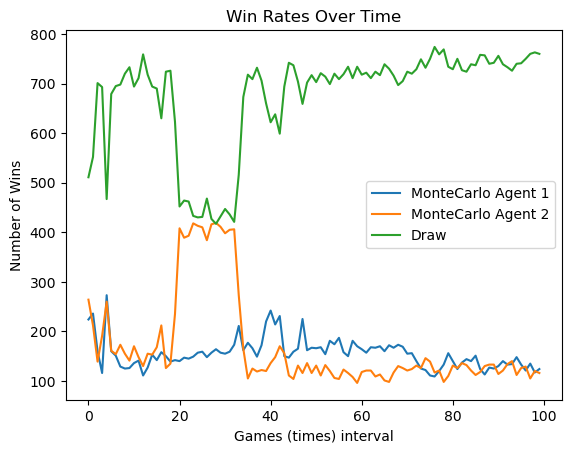

{'X': 15551, 'O': 17129, 'draw': 67320}


In [6]:
games = 100000
seed = 536
rng = np.random.default_rng(seed)

print(f"\nTRAINING: X: MCAgent, O: MCAgent -- {games} games")
mcagent1 = MCAgent("X")
mcagent2 = MCAgent("O")
result = match(mcagent1, mcagent2, games)
plot_win_counts(result[0], labels=["MonteCarlo Agent 1", "MonteCarlo Agent 2"])
print(result[1])

## Implementation of agent using Q-Learning

In [7]:
class QLearningAgent(TicTacToeAgent):
    def __init__(self, symbol, epsilon=0.1, alpha=0.5, gamma=0.9):
        super().__init__(symbol, epsilon)
        self.epsilon = epsilon
        self.gamma = gamma  # discount rate
        self.alpha = alpha  # step-size

    def new_game(self, board):
        self.state = None
        self.action = None
        self.afterstate = None
        self.past_event = []
        self.join_game(board)

    # When we receive the reward, we store it in the episode
    # and update the previous state value
    def reward(self, r, terminal=False):
        if self.state is None:
            return
        if not terminal:
            curr_optimal_action = self.select_action(epsilon=0)
            curr_best_afterstate_value = self.state_values[
                self.compute_afterstate(self.state, curr_optimal_action)
            ]
            if len(self.past_event) > 0:
                previous_afterstate = self.past_event[0]
                previous_reward = self.past_event[1]
                previous_afterstate_value = self.state_values[previous_afterstate]
                self.state_values[previous_afterstate] += self.alpha * (
                    previous_reward
                    + self.gamma * curr_best_afterstate_value
                    - previous_afterstate_value
                )
        self.past_event = [self.afterstate, r]

        # An update occurs of the previous state when the reward for the next state arrives.
        # Since a new state won't arrive for a terminal state, we will process this separetely
        if terminal:
            previous_afterstate = self.past_event[0]
            previous_reward = self.past_event[1]
            previous_afterstate_value = self.state_values[previous_afterstate]
            self.state_values[previous_afterstate] += self.alpha * (
                previous_reward - previous_afterstate_value
            )

    def end_game(self):
        self.num_games += 1


TRAINING: X: QLearningAgent, O: QLearningAgent -- 500000 games
Games 10000: X=3506, O=3587, Draw=2906
Games 20000: X=3013, O=2857, Draw=4130
Games 30000: X=3346, O=2956, Draw=3698
Games 40000: X=3458, O=2833, Draw=3709
Games 50000: X=3350, O=2539, Draw=4111
Games 60000: X=3131, O=2384, Draw=4485
Games 70000: X=3299, O=2252, Draw=4449
Games 80000: X=2632, O=2656, Draw=4712
Games 90000: X=3247, O=2800, Draw=3953
Games 100000: X=3043, O=2164, Draw=4793
Games 110000: X=3091, O=2792, Draw=4117
Games 120000: X=3030, O=2862, Draw=4108
Games 130000: X=2730, O=2082, Draw=5188
Games 140000: X=3454, O=2414, Draw=4132
Games 150000: X=2598, O=2971, Draw=4431
Games 160000: X=2962, O=2367, Draw=4671
Games 170000: X=2224, O=2147, Draw=5629
Games 180000: X=2330, O=2137, Draw=5533
Games 190000: X=2119, O=1910, Draw=5971
Games 200000: X=2429, O=2213, Draw=5358
Games 210000: X=2922, O=2057, Draw=5021
Games 220000: X=2258, O=2567, Draw=5175
Games 230000: X=2129, O=2369, Draw=5502
Games 240000: X=2776, O=2

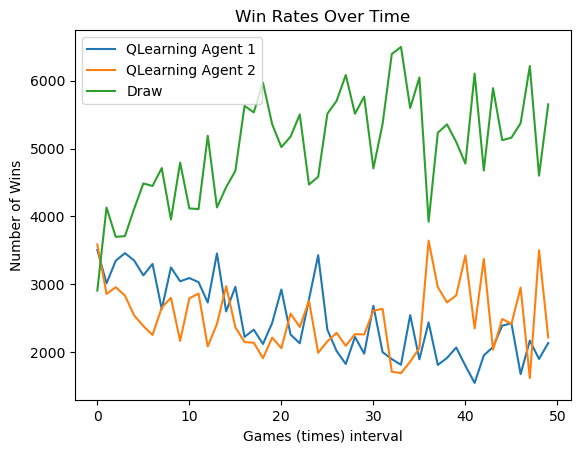

{'X': 123986, 'O': 124812, 'draw': 251202}


In [8]:
games = 500000
seed = 536
rng = np.random.default_rng(seed)

print(f"\nTRAINING: X: QLearningAgent, O: QLearningAgent -- {games} games")
qlearner1 = QLearningAgent("X")
qlearner2 = QLearningAgent("O")
result = match(qlearner1, qlearner2, games, interval=10000)
plot_win_counts(result[0], labels=["QLearning Agent 1", "QLearning Agent 2"])
print(result[1])

## Implementation of the deterministic MiniMax agent
This agent always takes an optimal move. This can be very slow, so we can cache the moves that the agent already took.

Also this will be $\epsilon$-greedy meaning, it will take the optimal move with probability $1-\epsilon$ and a random action with probability $\epsilon$. This will help train the RL agents better.

In [9]:
class MiniMaxAgent:
    def __init__(self, symbol, epsilon=0.3):
        self.symbol = symbol
        self.epsilon = epsilon
        self.opponent_symbol = "O" if symbol == "X" else "X"
        self.move_cache = dict()

    def new_game(self, board):
        self.state = None
        self.board = board

    def minimax(self, board, depth, is_maximizing):
        result = board.is_terminal()

        if result == self.symbol:
            return 10 - depth
        elif result == self.opponent_symbol:
            return depth - 10
        elif result == "draw":
            return 0

        if is_maximizing:
            best_value = -np.inf
            for move in board.get_possible_actions():
                board.mark(self.symbol, move)
                value = self.minimax(board, depth + 1, False)
                board.mark(" ", move)  # Undo the move
                best_value = max(best_value, value)
            return best_value
        else:
            best_value = np.inf
            for move in board.get_possible_actions():
                board.mark(self.opponent_symbol, move)
                value = self.minimax(board, depth + 1, True)
                board.mark(" ", move)  # Undo the move
                best_value = min(best_value, value)
            return best_value

    def select_action(self):
        best_value = -np.inf
        best_move = None

        for move in self.board.get_possible_actions():
            self.board.mark(self.symbol, move)
            move_value = self.minimax(self.board, 0, False)
            self.board.mark(" ", move)  # Undo the move

            if move_value > best_value:
                best_value = move_value
                best_move = move

        return best_move

    def board_to_state(self, board):
        state = 0
        for i in range(9):
            if board.board[i] == " ":
                s = 0
            elif board.board[i] == self.symbol:
                s = 1
            else:
                s = 2
            state += s * (3**i)
        return state

    def take_action(self):
        # take best action
        if rng.random() < 1 - self.epsilon:
            self.state = self.board_to_state(self.board)
            if self.state in self.move_cache:
                move = self.move_cache[self.state]
            else:
                move = self.select_action()
                self.move_cache[self.state] = move
            self.board.mark(self.symbol, move)
        else:
            move = rng.choice(self.board.get_possible_actions())
            self.board.mark(self.symbol, move)

        # take random action

    def reward(self, r, terminal=False):
        pass

    def end_game(self):
        pass

## Training the Monte Carlo agent by playing against the MiniMax agent


TRAINING: X: MCAgent, O: MiniMaxAgent -- 100000 games
Games 1000: X=200, O=443, Draw=356
Games 2000: X=290, O=287, Draw=423
Games 3000: X=314, O=153, Draw=533
Games 4000: X=338, O=161, Draw=501
Games 5000: X=345, O=163, Draw=492
Games 6000: X=349, O=137, Draw=514
Games 7000: X=361, O=136, Draw=503
Games 8000: X=368, O=127, Draw=505
Games 9000: X=355, O=145, Draw=500
Games 10000: X=354, O=119, Draw=527
Games 11000: X=346, O=135, Draw=519
Games 12000: X=417, O=115, Draw=468
Games 13000: X=359, O=111, Draw=530
Games 14000: X=400, O=126, Draw=474
Games 15000: X=372, O=130, Draw=498
Games 16000: X=400, O=117, Draw=483
Games 17000: X=380, O=120, Draw=500
Games 18000: X=394, O=115, Draw=491
Games 19000: X=406, O=114, Draw=480
Games 20000: X=403, O=113, Draw=484
Games 21000: X=407, O=117, Draw=476
Games 22000: X=366, O=125, Draw=509
Games 23000: X=391, O=106, Draw=503
Games 24000: X=382, O=102, Draw=516
Games 25000: X=402, O=115, Draw=483
Games 26000: X=417, O=98, Draw=485
Games 27000: X=387,

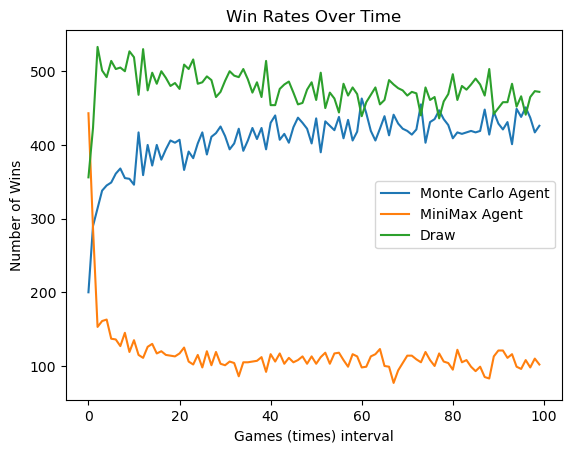

{'X': 40754, 'O': 11603, 'draw': 47643}


In [10]:
games = 100000
seed = 536
rng = np.random.default_rng(seed)

# Training with "epsilon-greedy" minimax agent
minimax_agent = MiniMaxAgent("O", epsilon=0.3)

print(f"\nTRAINING: X: MCAgent, O: MiniMaxAgent -- {games} games")
mcagent = MCAgent("X")
result = match(mcagent, minimax_agent, games)
plot_win_counts(result[0], labels=["Monte Carlo Agent", "MiniMax Agent"])
print(result[1])

## Training the Q-Learning agent by playing against the MiniMax agent


TRAINING: X: QLearningAgent, O: MiniMaxAgent -- 500000 games
Games 10000: X=2502, O=4125, Draw=3372
Games 20000: X=2732, O=3444, Draw=3824
Games 30000: X=3105, O=3177, Draw=3718
Games 40000: X=3324, O=3120, Draw=3556
Games 50000: X=3262, O=3045, Draw=3693
Games 60000: X=3459, O=2977, Draw=3564
Games 70000: X=3124, O=2942, Draw=3934
Games 80000: X=3184, O=2957, Draw=3859
Games 90000: X=3113, O=2908, Draw=3979
Games 100000: X=3313, O=2935, Draw=3752
Games 110000: X=3381, O=3016, Draw=3603
Games 120000: X=3101, O=3071, Draw=3828
Games 130000: X=3188, O=3034, Draw=3778
Games 140000: X=3329, O=3149, Draw=3522
Games 150000: X=3220, O=2900, Draw=3880
Games 160000: X=3211, O=3045, Draw=3744
Games 170000: X=3076, O=2972, Draw=3952
Games 180000: X=3124, O=2927, Draw=3949
Games 190000: X=3075, O=2910, Draw=4015
Games 200000: X=3292, O=2987, Draw=3721
Games 210000: X=3263, O=3115, Draw=3622
Games 220000: X=3169, O=3071, Draw=3760
Games 230000: X=3194, O=2786, Draw=4020
Games 240000: X=3330, O=280

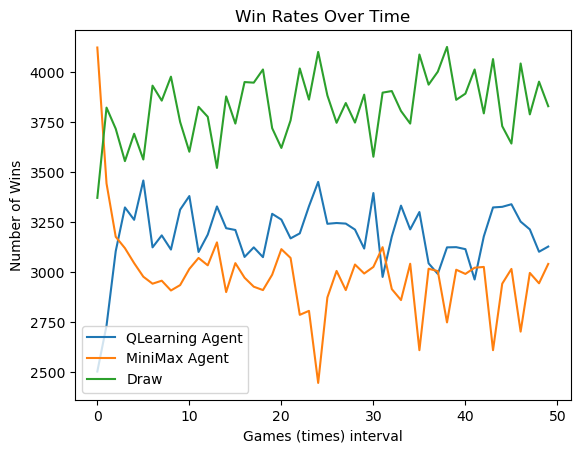

{'X': 159212, 'O': 149332, 'draw': 191456}


In [11]:
games = 500000
seed = 536
rng = np.random.default_rng(seed)

print(f"\nTRAINING: X: QLearningAgent, O: MiniMaxAgent -- {games} games")
qlearner = QLearningAgent("X")
result = match(qlearner, minimax_agent, games, interval=10000)
plot_win_counts(result[0], labels=["QLearning Agent", "MiniMax Agent"])
print(result[1])

We see that both agents learn, as the winning rates of MiniMaxAgent goes down
and the draw rates and win rates of both our RL agents go up.  
But clearly there is faster and better convergence in Monte Carlo agent than
the Q-Learning agent.

## Letting the two agents play against each other

We initialize both agents in the same way and let them play against each other and learn. We see whether one agent learns quickly and dominates and whetherDoes the other agent catch up eventually?


TRAINING: X: MCAgent, O: QLearningAgent -- 500000 games
Games 10000: X=3814, O=2211, Draw=3974
Games 20000: X=3353, O=1892, Draw=4755
Games 30000: X=4797, O=1230, Draw=3973
Games 40000: X=3819, O=1107, Draw=5074
Games 50000: X=4342, O=1149, Draw=4509
Games 60000: X=4381, O=1069, Draw=4550
Games 70000: X=4369, O=1106, Draw=4525
Games 80000: X=4631, O=998, Draw=4371
Games 90000: X=4515, O=971, Draw=4514
Games 100000: X=4699, O=984, Draw=4317
Games 110000: X=4555, O=1045, Draw=4400
Games 120000: X=4399, O=1073, Draw=4528
Games 130000: X=4469, O=1056, Draw=4475
Games 140000: X=4397, O=1121, Draw=4482
Games 150000: X=4277, O=1197, Draw=4526
Games 160000: X=4293, O=1137, Draw=4570
Games 170000: X=3707, O=1327, Draw=4966
Games 180000: X=2914, O=1305, Draw=5781
Games 190000: X=4104, O=1085, Draw=4811
Games 200000: X=4220, O=994, Draw=4786
Games 210000: X=4418, O=990, Draw=4592
Games 220000: X=4232, O=1116, Draw=4652
Games 230000: X=4330, O=960, Draw=4710
Games 240000: X=4277, O=1029, Draw=469

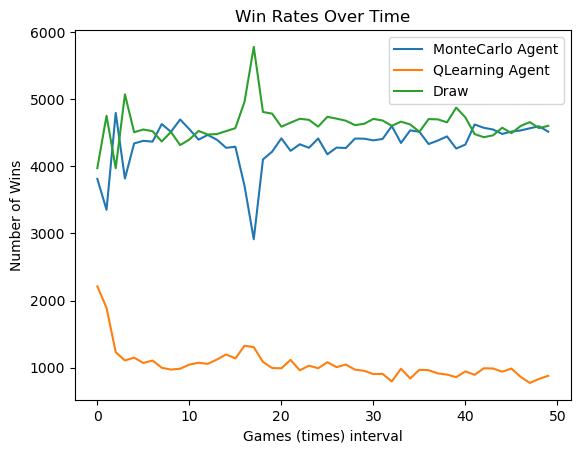

{'X': 216820, 'O': 52307, 'draw': 230873}


In [14]:
games = 500000
seed = 536
rng = np.random.default_rng(seed)

print(f"\nTRAINING: X: MCAgent, O: QLearningAgent -- {games} games")
mcagent3 = MCAgent("X")
qlearner3 = QLearningAgent("O")
result = match(mcagent3, qlearner3, games, interval=10000)
plot_win_counts(result[0], labels=["MonteCarlo Agent", "QLearning Agent"])
print(result[1])

Clearly, the Monte Carlo Agent learns much quicker and dominates the Q-Learning Agent.  
But the number of draws increase as the number of episodes increase, which means the QLearning agent is catching up.  
One reason why Q-Learning Agent doesn't win a lot is because it doesn't get enough chances to win and doesn't get enough chances to learn from thate

# Identifying winning positions using an RL agent

Once our agents have learnt optimal policies, they are good enough to force wins from certain situations of the board. We will identify such situations using functions that your agent has learnt.

To find such states, we can collect the states with very high state values.

In [15]:
# First we will try to visualize the distribution of state values across states

def plot_state_value_distribution(state_value_dict):
    state_values = list(state_value_dict.values())

    plt.figure(figsize=(10, 6))
    counts, bin_edges, _ = plt.hist(state_values, bins=20, edgecolor='black')

    # Set the x-ticks to the bin centers and rotate labels if necessary
    plt.xticks(bin_edges, labels=np.round(bin_edges, 2), rotation=45)
    
    plt.title('Distribution of State Values')
    plt.xlabel('State Value')
    plt.ylabel('Frequency')
    plt.show()

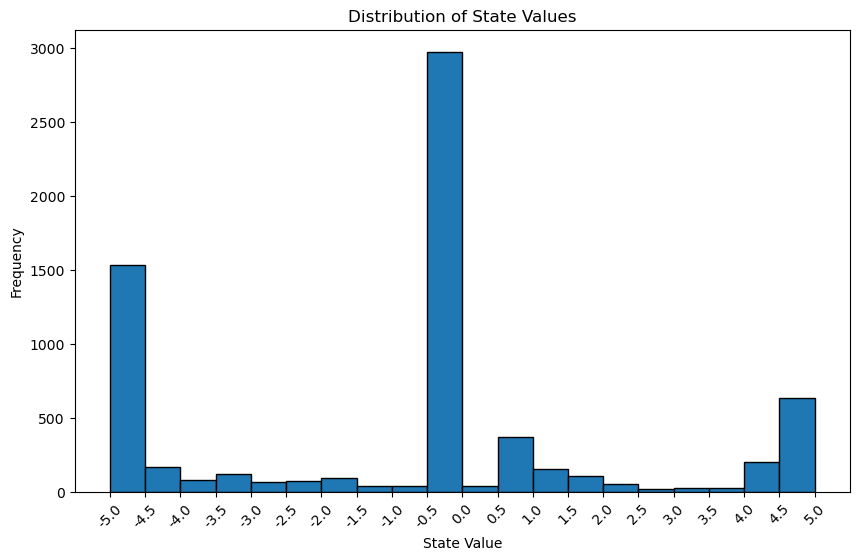

In [16]:
# We will use the trained Monte Carlo agent against the epsilon-greedy Minimax agent

agent = mcagent
plot_state_value_distribution(agent.state_values)

In [17]:
# Output TicTacToeBoard object with agent's symbol as "X" and opponent's as "O"
def state_to_board(state, agent):
    agent_board = agent.state_to_board(state)
    board = np.full(9, " ")
    board[agent_board == 1] = "X"
    board[agent_board == 2] = "O"
    board = TicTacToeBoard(board)
    return board

In [18]:
# To verify this, we will create and batte
# two Minimax agents with epsilon=0

minimax1 = MiniMaxAgent("X", epsilon=0)
minimax2 = MiniMaxAgent("O", epsilon=0)

win_count = {"X": 0, "O": 0, "draw": 0}

threshold = 3
agent = mcagent

winning_pos = []
for state in agent.state_values:
    if agent.state_values[state] >= threshold:
        high_value_board = state_to_board(state, agent)
        # Ignore terminal boards
        if high_value_board.is_terminal() == "X":
            pass
        elif high_value_board.is_terminal() == "O":
            print("Something is wrong!")
            break
        else:
            # Since we were storing the values of afterstates, minimax2 plays first
            game = TicTacToeGame(minimax2, minimax1, high_value_board)
            winner = game.game()
            win_count[winner] += 1
            if winner == "X":
                winning_pos.append(high_value_board)

print(win_count)

{'X': 229, 'O': 12, 'draw': 8}


Out of $249$ states with `state_values` $\geq 3$, the minimax agent won $229$ games and lost or drawed only $20$.  